This notebook demonstrates the usage of domain decomposition in a simulation, including how to set up domain decomposition inputs, run the simulation and post-process data from statepoint files of domain-decomposed runs using the Python API.


In [1]:
%matplotlib inline
import glob
from IPython.display import Image
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pandas as pd

import openmc

## Generate Input Files

Generally, except that the domain decomposition parameters need to be added in the "settings.xml" file, the ways to define materials, geometry, tallies and plots are the same as normal modeling.

**Create materials**

Three materials for the fuel, water, and cladding of the fuel pin are created and written to materials XML file.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H1')
b10 = openmc.Nuclide('B10')
o16 = openmc.Nuclide('O16')
u235 = openmc.Nuclide('U235')
u238 = openmc.Nuclide('U238')
zr90 = openmc.Nuclide('Zr90')

# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

# Create materials file
# Instantiate a Materials collection
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

**Create geometry**

This problem will be a 17x17 rectangular lattice with a 1.26 cm pitch while each pitch contains three regions for the fuel, the clad, and the surrounding coolant.

In [3]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
# Use both reflective and vacuum boundaries to make life interesting
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-10.71, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10.71, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10.71, boundary_type='reflective')

# Create a Universe to encapsulate a fuel pin
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
pin_cell_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
pin_cell_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator_cell)

# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel - 0BA')
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2
assembly.universes = [[pin_cell_universe] * 17] * 17

# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

# Export to "geometry.xml"
geometry.export_to_xml()

**Simulation parameters**

In this case, we will use 20 inactive batches and 80 active batches each with 2000 particles.

In [4]:
# OpenMC simulation parameters
batches = 80
inactive = 20
particles = 2000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

Now we can **set up domain decomposition parameters**. By defining a 2x2x1 cartesian mesh in size of 22cmx22cmx22cm, we are going to simulate this model using 4 domains. The domain mesh region is defined to be a bit larger than the lattice so that the whole geometry are covered. Since the 4 domains are symmetric, a uniform nodemap is defined.

In [5]:
# Domain mesh
settings_file.dd_mesh_dimension = [2, 2, 1]
settings_file.dd_mesh_lower_left = [-11, -11, -11]
settings_file.dd_mesh_upper_right = [11,  11,  11]

# Nodemap to specify the distribution of load for all domains
settings_file.dd_nodemap = [1, 1, 1, 1]

# Whether or not to counts all particle interactions in all domains
settings_file.dd_count_interactions = True

Let's generate the "settings.xml" input file.

In [6]:
# Export to "settings.xml"
settings_file.export_to_xml()

**Plot geometry with domain meshlines**

Let us create a plot file to verify that our pin cell geometry was created successfully. The domain meshlines are to be plotted on top of the geometry figure.

In [7]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.width = [22.5, 22.5]
plot.pixels = [250, 250]
plot.color = 'mat'

# Plot domain meshlines and set line color to be green
plot.meshlines = {
    'type': 'domain_decomposition',
    'linewidth': 1,
    'color': (0,255,0)
}

# Instantiate a Plots collection and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [8]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

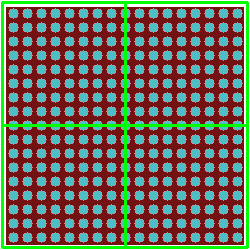

In [9]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As can be seen from the plot, we have constructed a nice array of pin cells and the spatial geometry was divided into 4 domains in xy plane.

**Create tallies**

We will set up a fission rate mesh tally, a cell tally with nuclides and a "distribcell" tally.

In [10]:
# Instantiate an empty Tallies object
tallies_file = openmc.Tallies()
tallies_file._tallies = []

# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.width = [1.26, 1.26]

# Instantiate tally Filter
mesh_filter = openmc.Filter()
mesh_filter.mesh = mesh

# Instantiate energy Filter
energy_filter = openmc.Filter()
energy_filter.type = 'energy'
energy_filter.bins = np.array([0, 0.625e-6, 20.])

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter, energy_filter]
tally.scores = ['fission', 'nu-fission']

# Add mesh and Tally to Tallies
tallies_file.append(tally)

# Instantiate tally Filter
cell_filter = openmc.Filter(type='cell', bins=[fuel_cell.id])

# Instantiate the tally
tally = openmc.Tally(name='cell tally')
tally.filters = [cell_filter]
tally.scores = ['scatter-y2']
tally.nuclides = [u235, u238]

# Add mesh and tally to Tallies
tallies_file.append(tally)

# Instantiate tally Filter
distribcell_filter = openmc.Filter(type='distribcell', bins=[moderator_cell.id])

# Instantiate the Tally
tally = openmc.Tally(name='distribcell tally')
tally.filters = [distribcell_filter]
tally.scores = ['absorption', 'scatter']

# Add mesh and tally to Tallies
tallies_file.append(tally)

# Export to "tallies.xml"
tallies_file.export_to_xml()

## Run OpenMC

Now we a have a complete set of inputs, so we can go ahead and run our simulation. Note that domain decomposed cases must be run in a MPI parallel mode and the number of parallel processors **must be equal or greater** than the number of domains.

In [11]:
# Run OpenMC!
openmc.run(mpi_procs=4)


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

## Tally Data Processing

The domain decomposed simulation ran successfully. A statepoint files was created at the end of simulation. It should be noted that in domain decomposed runs, tally arrays are allocated in a "on-the-fly" way and tally results are accumulated for each domain. In the statepoint file, domain-specified on-the-fly tallies rather than the normally reduced tally results are written inside a new group "on_the_fly_results" for each tally. Tally data of different on-the-fly processes are written in different sub-groups "proc_i", where "*i*" represents the domain id.

Since tally results are seperated in multiple groups for dd runs, some merging work should be done to get the whole tally data. OpenMC Python API can do this job easily. Once the statepoint file is loaded, the Python API will automatically link all domain-specified groups and merge the tally data together. All the features for tally processing can be used normally.

In [12]:
# Load statepoint file
sp = openmc.StatePoint('statepoint.80.h5')

We can check the domain decomposition infomation, like the number of domains, domain mesh, nodemap, etc.

In [13]:
print("Domain decomposition ative: {0}".format(sp.domain_decomp_on))
print("Number of domains: {0}".format(sp.domain_number))
print("Load ditribution: {0}".format(sp.domain_nodemap))
print("Counts of interactions: {0}".format(sp.domain_n_interactions))
print("Domain mesh: {0}".format(sp.domain_decomp_mesh))

Domain decomposition ative: True
Number of domains: 4
Load ditribution: [ 0.25  0.25  0.25  0.25]
Counts of interactions: [3837485 2042597 7307991 3864515]
Domain mesh: Mesh
	ID             =	10000
	Name           =	domain decomposition mesh
	Type           =	regular
	Basis          =	[2 2 1]
	Width          =	[-11. -11. -11.]
	Origin         =	[ 11.  11.  11.]
	Pixels         =	[ 11.  11.  22.]



**Analyze the mesh fission rate tally**

In [14]:
# Find the mesh tally with the StatePoint API
tally = sp.get_tally(name='mesh tally')

# Print a little info about the mesh tally to the screen
print(tally)

Tally
	ID             =	10000
	Name           =	mesh tally
	Filters        =	
                		mesh	[1]
                		energy	[  0.00000000e+00   6.25000000e-07   2.00000000e+01]
	Nuclides       =	total 
	Scores         =	[u'fission', u'nu-fission']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [15]:
# Get the relative error for the thermal fission reaction 
# rates in the four corner pins 
data = tally.get_values(scores=['fission'], filters=['mesh', 'energy'], \
                        filter_bins=[((1,1),(1,17), (17,1), (17,17)), \
                                    ((0., 0.625e-6),)], value='rel_err')
print(data)

[[[ 0.09689803]]

 [[ 0.20368993]]

 [[ 0.04130542]]

 [[ 0.09271221]]]


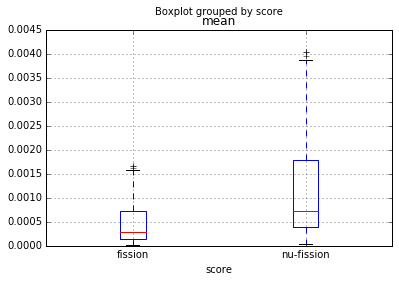

In [16]:
# Get a pandas dataframe for the mesh tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Create a boxplot to view the distribution of
# fission and nu-fission rates in the pins
bp = df.boxplot(column='mean', by='score')

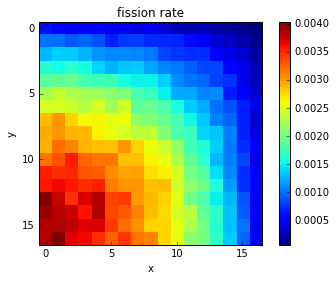

In [17]:
# Extract thermal nu-fission rates from pandas
fiss = df[df['score'] == 'nu-fission']
fiss = fiss[fiss['energy low [MeV]'] == 0.0]

# Extract mean and reshape as 2D NumPy arrays
mean = fiss['mean'].reshape((17,17))

plt.imshow(mean, interpolation='nearest')
plt.title('fission rate')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

**Analyze the cell+nuclides scatter-y2 rate tally**

In [18]:
# Find the cell Tally with the StatePoint API
tally = sp.get_tally(name='cell tally')

# Print a little info about the cell tally to the screen
print(tally)

Tally
	ID             =	10001
	Name           =	cell tally
	Filters        =	
                		cell	[10000]
	Nuclides       =	U235 U238 
	Scores         =	[u'scatter-Y0,0', u'scatter-Y1,-1', u'scatter-Y1,0', u'scatter-Y1,1', u'scatter-Y2,-2', u'scatter-Y2,-1', u'scatter-Y2,0', u'scatter-Y2,1', u'scatter-Y2,2']
	Estimator      =	analog



In [19]:
# Get a pandas dataframe for the cell tally data
df = tally.get_pandas_dataframe()

# Print the first twenty rows in the dataframe
df.head(100)

,cell,nuclide,score,mean,std. dev.
0,10000,U235,"scatter-Y0,0",0.037955,0.001142
1,10000,U235,"scatter-Y1,-1",0.000714,0.000396
2,10000,U235,"scatter-Y1,0",0.000109,0.000367
3,10000,U235,"scatter-Y1,1",-0.000498,0.000389
4,10000,U235,"scatter-Y2,-2",-0.000098,0.000248
5,10000,U235,"scatter-Y2,-1",-0.000254,0.000231
6,10000,U235,"scatter-Y2,0",0.000131,0.000234
7,10000,U235,"scatter-Y2,1",0.000229,0.000255
8,10000,U235,"scatter-Y2,2",0.000095,0.000237
9,10000,U238,"scatter-Y0,0",2.329688,0.015058


Use the new Tally data retrieval API with pure NumPy

In [20]:
# Get the standard deviations for two of the spherical harmonic
# scattering reaction rates 
data = tally.get_values(scores=['scatter-Y2,2', 'scatter-Y0,0'], 
                        nuclides=['U238', 'U235'], value='std_dev')
print(data)

[[[ 0.00194414  0.01505781]
  [ 0.00023746  0.00114201]]]


**Analyze the distribcell tally**

In [21]:
# Find the distribcell Tally with the StatePoint API
tally = sp.get_tally(name='distribcell tally')

# Print a little info about the distribcell tally to the screen
print(tally)

Tally
	ID             =	10002
	Name           =	distribcell tally
	Filters        =	
                		distribcell	[10002]
	Nuclides       =	total 
	Scores         =	[u'absorption', u'scatter']
	Estimator      =	tracklength



Use the new Tally data retrieval API with pure NumPy

In [22]:
# Get the relative error for the scattering reaction rates in
# the first 10 distribcell instances 
data = tally.get_values(scores=['scatter'], filters=['distribcell'],
                        filter_bins=[(i,) for i in range(10)], value='rel_err')
print(data)

[[[ 0.02540081]]]


Print the distribcell tally dataframe

In [23]:
# Get a pandas dataframe for the distribcell tally data
df = tally.get_pandas_dataframe(nuclides=False)

# Show summary statistics for absorption distribcell tally data
absorption = df[df['score'] == 'absorption']
absorption[['mean', 'std. dev.']].dropna().describe()

,mean,std. dev.
,,
,,
count,289.000000,289.000000
mean,0.000415,0.000014
std,0.000240,0.000006
min,0.000016,0.000002
25%,0.000208,0.000010
50%,0.000391,0.000014
75%,0.000627,0.000019
max,0.000874,0.000030


## Source Sites

Source sites are collectively written to the statepoint file for dd runs, and the source sites can be accessed from the `source` property just as the non-dd runs.

In [24]:
sp.source

array([ (1.0025062656641603, [-3.446849704537044, -3.734481864084478, 4.760646701527949], [-0.9277011340076977, -0.2876578563067349, 0.23795706265174307], 7.974254639951965, [9077870282235869184, 9077870282235869184, 9077870282235869184, 9077870282235869184, 9077870282235869184], 0),
       (1.0025062656641603, [-7.603944101398868, -8.983974389623876, 1.0949603403381514], [0.4118127562769325, 0.07157262573004007, 0.9084534181859317], 0.6183063063203122, [4064788676905248256, 4064788676905248256, 4064788676905248256, 4064788676905248256, 4064788676905248256], 0),
       (1.0025062656641603, [-9.015720622152816, -6.434176907570426, -8.337066526161843], [0.7367416838038239, -0.6581842133142332, -0.15493622136166357], 2.9330523809707065, [1844997265617302016, 1844997265617302016, 1844997265617302016, 1844997265617302016, 1844997265617302016], 0),
       ...,
       (1.0025062656641603, [0.9798367816951745, 3.5106351846289927, 1.3571664565423787], [0.7821895088217017, -0.3724330830155733, -

Note it is possible for domain-deomposed runs that the number of source sites is not equal to number of particles.

In [25]:
print(sp.source.size)
print(sp.n_particles)

1995
2000


The "domain_work_index" records the work ditribution (source bank size) of all proceses for dd runs.

In [26]:
sp.domain_work_index

array([   0,  483,  733, 1541, 1995])

We can extract and plot the energy distribution of source sites.

1.0


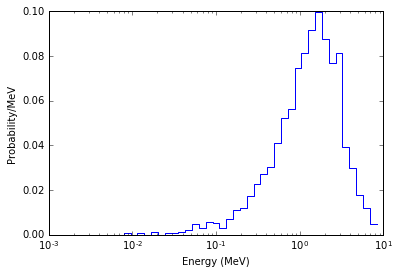

In [27]:
# Create log-spaced energy bins from 1 keV to 100 MeV
energy_bins = np.logspace(-3,1)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), linestyle='steps')
plt.xlabel('Energy (MeV)')
plt.ylabel('Probability/MeV')